In [1]:
import datetime
import gc
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import scipy.stats
import seaborn as sns
import sys
sys.path.append("../../")
import time
import warnings
warnings.simplefilter("ignore")
from collections import defaultdict
from itertools import repeat, combinations
from pandarallel import pandarallel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tqdm import tqdm

In [2]:
from utils.common import (
    sigmoid, pad_column_name
)
from utils.constants import *
from utils.eval_helpers import (
    plot_roc_curves, plot_feature_importance, 
    amex_metric, get_final_metric_df, amex_metric_np, lgb_amex_metric
)
from utils.eda_helpers import (
    plot_missing_proportion_barchart, plot_heatmap,
    get_cols, insert_row_number, plot_train_test_distribution
)
from utils.extraction_helpers import read_file
from utils.feature_group import CATEGORY_COLUMNS

In [3]:
from feature_engineering_helpers import feature_gen_pipeline

In [4]:
%load_ext autoreload
%autoreload

In [5]:
pandarallel.initialize(nb_workers=16, progress_bar=False, use_memory_fs=False)

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [6]:
START = time.time()

In [7]:
def combine_binary_features(train, test, final_col_name, col_list, sufficient_count=500, drop_ori=False):
    train["temp"] = train[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    test["temp"] = test[col_list].astype(str).parallel_apply(lambda x: ''.join(x), axis=1)
    le = LabelEncoder()
    le.fit(train["temp"])
    le_dict = dict(zip(le.classes_, le.transform(le.classes_)))
    train_df = train.groupby("temp").agg(
        target_count=("target", "count")
    )
    less_count_cat_codes = train_df.loc[train_df["target_count"] < sufficient_count].index.tolist()
    le_dict = {k: v if k not in less_count_cat_codes else np.nan for k, v in le_dict.items()}
    train[final_col_name] = train["temp"].map(le_dict).astype("category")
    test[final_col_name] = test["temp"].map(le_dict).astype("category")
    if drop_ori:
        train.drop(columns=col_list, inplace=True)
        test.drop(columns=col_list, inplace=True)
    return train, test

## V5

### Read Data

In [8]:
labels = read_file(f"../{RAW_DATA_PATH}/train_labels.csv")

Shape of data: (458913, 2)


In [9]:
%%time
train = read_file(f"../{INTERIM_DATA_PATH}/v4/train_parquet/train_all_variables.parquet")
test1 = read_file(f"../{INTERIM_DATA_PATH}/v4/test_parquet/test_all_variables1.parquet")
test2 = read_file(f"../{INTERIM_DATA_PATH}/v4/test_parquet/test_all_variables2.parquet")

Shape of data: (5531451, 192)
Shape of data: (5681079, 191)
Shape of data: (5682683, 191)
CPU times: user 16.5 s, sys: 15.4 s, total: 32 s
Wall time: 18.2 s


In [10]:
# test = pd.concat([test1, test2], ignore_index=True)
# del test1, test2

In [11]:
gc.collect()

36

### Train

In [ ]:
train = train.loc[train["row_number"] <= 9].reset_index(drop=True)

In [20]:
%%time
train_agg, keep_column = feature_gen_pipeline(train)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:37<00:00,  4.67it/s]

CPU times: user 57.4 s, sys: 26 s, total: 1min 23s
Wall time: 1min 32s


In [21]:
train_agg["target"] = labels["target"].values
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 14.072963405 GB, Shape: (458913, 4974)


In [22]:
float64_columns = train_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = train_agg[col].astype(np.float32).values
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2680/2680 [00:32<00:00, 83.31it/s]


In [23]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.199307345 GB, Shape: (458913, 4974)


In [24]:
number_columns = train_agg.select_dtypes(np.number).columns.tolist()
for col in tqdm(number_columns):
    temp = train_agg[col].round(3)
    if (temp - train_agg[col]).abs().max() < 1e-4:
        train_agg[col] = train_agg[col].round(3)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4930/4930 [00:17<00:00, 285.49it/s]


In [25]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 9.199307345 GB, Shape: (458913, 4974)


In [26]:
%%time
train_agg = train_agg.loc[:, keep_column]

CPU times: user 1.43 s, sys: 10.2 s, total: 11.6 s
Wall time: 18.6 s


In [27]:
print(f"Size: {sys.getsizeof(train_agg) / 1e9} GB, Shape: {train_agg.shape}")

Size: 8.868889985 GB, Shape: (458913, 4796)


In [28]:
train_agg.to_parquet(f"./train_agg_v5.5.parquet")

In [29]:
del train_agg, train

### Test 1

In [30]:
%%time
test1 = test1.loc[test1["row_number"] <= 9].reset_index(drop=True)

In [31]:
%%time
test_agg, keep_column = feature_gen_pipeline(test1)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:37<00:00,  4.71it/s]

CPU times: user 57.4 s, sys: 17.3 s, total: 1min 14s
Wall time: 1min 17s


In [32]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 14.180739235 GB, Shape: (462311, 4973)


In [33]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2684/2684 [00:34<00:00, 77.27it/s]


In [34]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.263599439 GB, Shape: (462311, 4973)


In [35]:
test_agg = test_agg.loc[:, keep_column]

In [36]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.934434007 GB, Shape: (462311, 4796)


In [37]:
test_agg.to_parquet(f"./test_agg1_v5.5.parquet")

In [38]:
del test_agg

In [39]:
del test1

### Test 2

In [40]:
test2 = test2.loc[test2["row_number"] <= 9].reset_index(drop=True)

In [41]:
%%time
test_agg, keep_column = feature_gen_pipeline(test2)

Done insertion
Average done
Minimum done
Maximum done
Standard Deviation done
Last entry done
First entry done
Second last entry done
Third last entry done
MA2 for Recency 1 done
MA2 for Recency 2 done
MA2 for Recency 3 done
MA2 for least Recency done
MA3 for Recency 1 done
MA3 for Recency 2 done


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 176/176 [00:37<00:00,  4.70it/s]

CPU times: user 57.2 s, sys: 16.5 s, total: 1min 13s
Wall time: 1min 16s


In [42]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 14.180708598 GB, Shape: (462310, 4973)


In [43]:
float64_columns = test_agg.select_dtypes("float64").columns.tolist()
for col in tqdm(float64_columns):
    temp = test_agg[col].astype(np.float32).values
    if (temp - test_agg[col]).abs().max() < 1e-4:
        test_agg[col] = test_agg[col].astype(np.float32)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2684/2684 [00:32<00:00, 83.09it/s]


In [44]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 9.267277918 GB, Shape: (462310, 4973)


In [45]:
%%time
test_agg = test_agg.loc[:, keep_column]

CPU times: user 1.34 s, sys: 8.69 s, total: 10 s
Wall time: 16.4 s


In [46]:
print(f"Size: {sys.getsizeof(test_agg) / 1e9} GB, Shape: {test_agg.shape}")

Size: 8.938113198 GB, Shape: (462310, 4796)


In [47]:
test_agg.to_parquet(f"./test_agg2_v5.5.parquet")

In [48]:
del test_agg

### Prepare final features for training

In [49]:
def select_bad_features(feature_imp_df, threshold):
    bad_features = []
    feature_imp_df = feature_imp_df.fillna(0)
    for type_ in feature_imp_df.columns[1:]:
        bad_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] < threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return bad_features

In [50]:
def select_good_features(feature_imp_df, threshold):
    good_features = []
    for type_ in feature_imp_df.columns[1:]:
        good_features.extend(
            (
                feature_imp_df.loc[feature_imp_df[type_] >= threshold]["base_feature"] + "_" + type_
            ).tolist()
        )
    # print(len(good_features), feature_imp_df.shape[0] * (feature_imp_df.shape[1] - 1))
    return good_features

### Train

In [51]:
%%time
train_agg = read_file(f"./train_agg_v5.5.parquet")

Shape of data: (458913, 4797)
CPU times: user 17 s, sys: 20 s, total: 37 s
Wall time: 29.5 s


In [52]:
train_agg.head(3)

,customer_ID,B_11_displacement,D_56_min,R_9_third_last,R_6_general_trend,S_26_ma3_r2,D_78_last_minus_ma2_r2,S_12_ma3_r2,D_76_coef_var,B_16_ma2_r1_r3,...,D_107_avg,D_62_max,D_81_last,B_27_ma2_r2,S_3a_previous_sprint,D_124_sprint,S_11_acceleration,D_137_std,B_22_ma2_r1,R_26_ma3_r1_r2
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,NaN,0.15,NaN,NaN,0.016667,0.0,0.115,NaN,NaN,...,2.0,0.45,0.0,0.0,1.0,0.0,-4.0,NaN,0.0,NaN
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,NaN,0.68,NaN,NaN,0.000000,0.0,NaN,NaN,0.0,...,0.0,0.24,0.0,0.0,20.0,0.0,NaN,NaN,0.0,NaN
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,NaN,0.20,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,...,0.0,0.44,0.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN


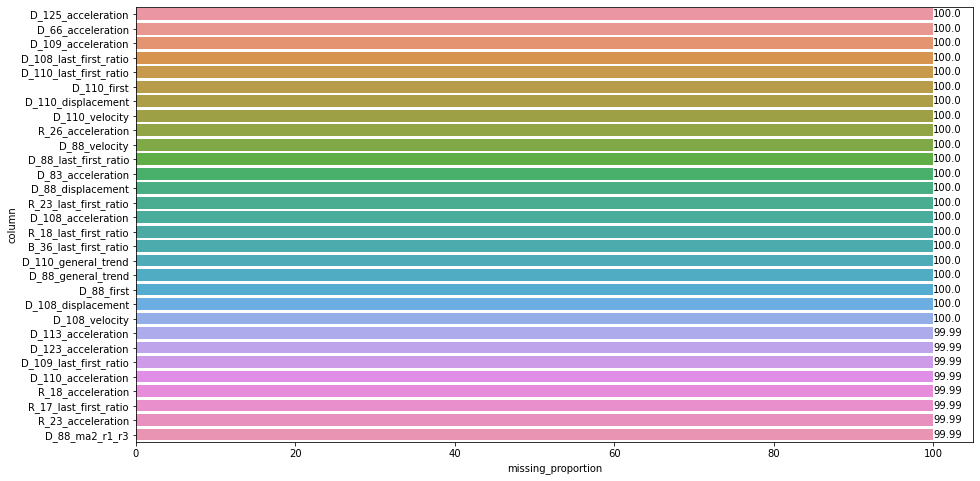

CPU times: user 2.84 s, sys: 2.31 s, total: 5.15 s
Wall time: 4.09 s


In [53]:
%%time
m = plot_missing_proportion_barchart(train_agg)

In [54]:
high_missing_columns = m.loc[m["missing_proportion"] > 99.5]["column"].tolist()
len(high_missing_columns)

223

In [55]:
%%time
train_agg = train_agg.drop(columns=high_missing_columns, errors="ignore")

CPU times: user 422 ms, sys: 1.08 s, total: 1.5 s
Wall time: 2.45 s


In [56]:
train_agg.shape

(458913, 4574)

In [57]:
summary_feature_imp3 = read_file(f"../{EXP_PATH}/3.lgbm_dart_5197/feature_importance.csv")
summary_feature_imp4 = read_file(f"../{EXP_PATH}/4.lgbm_dart_6666/feature_importance.csv")
summary_feature_imp5 = read_file(f"../{EXP_PATH}/5.lgbm_dart_923_half_fix/feature_importance.csv")

Shape of data: (166, 24)
Shape of data: (174, 24)
Shape of data: (181, 39)


In [58]:
median_fi3 = np.percentile(summary_feature_imp3.values[:, 1:].ravel(), 10)
median_fi4 = np.percentile(summary_feature_imp4.values[:, 1:].ravel(), 15)
median_fi5 = np.percentile(summary_feature_imp5.values[:, 1:].ravel(), 10)
median_fi3, median_fi4, median_fi5

(36.940000000000005, 33.2, 5.4)

In [63]:
bad_features = list(
    set(select_bad_features(summary_feature_imp3, 35))
    .intersection(select_bad_features(summary_feature_imp4, 35))
    .intersection(select_bad_features(summary_feature_imp5, 15))
    .intersection(train_agg.columns)
)
len(bad_features)

9

In [64]:
train_agg.shape

(458913, 4574)

In [65]:
%%time
train_agg = train_agg.drop(columns=bad_features)

CPU times: user 401 ms, sys: 2.66 s, total: 3.06 s
Wall time: 5.15 s


In [66]:
train_agg.shape

(458913, 4015)

In [68]:
train_agg.to_parquet(f"./final_train_agg_v5.5.parquet")

In [69]:
final_columns = train_agg.columns.tolist()

In [70]:
final_cat_columns = get_cols(train_agg, CATEGORY_COLUMNS)
print(final_cat_columns)

['D_68_first', 'D_63_last', 'D_116_second_last', 'D_120_second_last', 'D_68_third_last', 'D_117_last', 'D_116_third_last', 'B_38_first', 'D_63_third_last', 'D_116_last', 'D_68_second_last', 'D_120_first', 'D_92_third_last', 'D_63_second_last', 'D_92_first', 'D_114_last', 'D_114_second_last', 'D_64_second_last', 'D_92_last', 'D_117_second_last', 'D_120_third_last', 'D_120_last', 'D_68_last', 'D_92_second_last', 'D_116_first', 'D_117_third_last', 'D_64_third_last', 'D_63_first', 'D_126_third_last', 'B_38_second_last', 'D_64_last', 'B_30_third_last', 'D_114_third_last', 'B_38_last', 'D_126_first', 'D_64_first', 'B_38_third_last', 'B_30_last', 'D_114_first', 'D_117_first']


In [71]:
del train_agg

In [72]:
drop_features = bad_features + high_missing_columns

### Test

In [8]:
temp = read_file(f"./final_train_agg_v5.5.parquet")

Shape of data: (458913, 4015)


In [9]:
temp.columns

Index(['customer_ID', 'B_11_displacement', 'D_56_min', 'R_9_third_last',
       'R_6_general_trend', 'S_26_ma3_r2', 'D_78_last_minus_ma2_r2',
       'S_12_ma3_r2', 'D_76_coef_var', 'B_16_ma2_r1_r3',
       ...
       'D_46_last_minus_ma2_r2', 'R_16_ma3_r1_r2', 'D_107_avg', 'D_62_max',
       'B_27_ma2_r2', 'S_3a_previous_sprint', 'S_11_acceleration', 'D_137_std',
       'B_22_ma2_r1', 'R_26_ma3_r1_r2'],
      dtype='object', length=4015)

In [ ]:
['D_112_sprint', 'R_5_avg', 'D_136_min', 'D_140_last_minus_avg', 'P_4_previous_sprint', 
 'D_42_sprint', 'B_22_max', 'S_17_sprint', 'R_10_last']

In [10]:
%%time
test_agg1 = read_file(f"./test_agg1_v5.5.parquet")

Shape of data: (462311, 4796)
CPU times: user 16 s, sys: 21.1 s, total: 37 s
Wall time: 20.4 s


In [12]:
%%time
test_agg1 = test_agg1.loc[:, temp.columns[1:]]

CPU times: user 348 ms, sys: 1.91 s, total: 2.25 s
Wall time: 3.65 s


In [13]:
%%time
test_agg2 = read_file(f"./test_agg2_v5.5.parquet")

Shape of data: (462310, 4796)
CPU times: user 15.7 s, sys: 21.3 s, total: 37 s
Wall time: 27.8 s


In [14]:
%%time
test_agg2 = test_agg2.loc[:, temp.columns[1:]]

CPU times: user 334 ms, sys: 2.07 s, total: 2.41 s
Wall time: 3.63 s


In [15]:
del temp

In [16]:
test_agg = pd.concat([test_agg1, test_agg2], ignore_index=True)

In [17]:
del test_agg1, test_agg2

In [18]:
gc.collect()

635

In [19]:
test_agg.shape

(924621, 4014)

In [20]:
%%time
test_agg.to_parquet(f"./final_test_agg_v5.5.parquet")

CPU times: user 1min 2s, sys: 14.8 s, total: 1min 17s
Wall time: 1min 3s


### END

In [21]:
END = time.time()

In [22]:
print(f"{END - START:.2f} seconds elapsed")

244.18 seconds elapsed
